<a href="https://colab.research.google.com/github/VigneshPillai2004/CCL/blob/main/BDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark findspark


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("EarthquakeAnalysis") \
    .master("local[*]") \
    .getOrCreate()

spark


In [3]:
!wget https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.csv -O earthquakes.csv


--2025-09-24 17:58:42--  https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.csv
Resolving earthquake.usgs.gov (earthquake.usgs.gov)... 3.167.138.72, 3.167.138.2, 3.167.138.117, ...
Connecting to earthquake.usgs.gov (earthquake.usgs.gov)|3.167.138.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘earthquakes.csv’

earthquakes.csv         [ <=>                ]   1.88M  --.-KB/s    in 0.08s   

2025-09-24 17:58:42 (24.9 MB/s) - ‘earthquakes.csv’ saved [1973646]



In [4]:
# Load earthquake CSV
eq_df = spark.read.csv("earthquakes.csv", header=True, inferSchema=True)

# Preview data
eq_df.show(5)
eq_df.printSchema()


+--------------------+----------+------------+------+----+-------+---+----+-------+----+---+------------+--------------------+--------------------+----------+---------------+----------------+--------+------+---------+--------------+---------+
|                time|  latitude|   longitude| depth| mag|magType|nst| gap|   dmin| rms|net|          id|             updated|               place|      type|horizontalError|      depthError|magError|magNst|   status|locationSource|magSource|
+--------------------+----------+------------+------+----+-------+---+----+-------+----+---+------------+--------------------+--------------------+----------+---------------+----------------+--------+------+---------+--------------+---------+
|2025-09-24 17:39:...|    31.529|    -104.013|5.1825| 1.7|     ml| 33|57.0|    0.0| 0.4| tx|tx2025svqgxj|2025-09-24 17:42:...|31 km NW of Toyah...|earthquake|            0.0| 2.0628886222839|     0.2|    24|automatic|            tx|       tx|
|2025-09-24 17:14:...|    31

In [5]:
# Total number of earthquakes
print("Total earthquakes:", eq_df.count())

# Count distinct locations
print("Distinct places:", eq_df.select("place").distinct().count())

# Select relevant columns for analysis
eq_df = eq_df.select("time", "latitude", "longitude", "depth", "mag", "place")
eq_df.show(5)


Total earthquakes: 9961
Distinct places: 5248
+--------------------+----------+------------+------+----+--------------------+
|                time|  latitude|   longitude| depth| mag|               place|
+--------------------+----------+------------+------+----+--------------------+
|2025-09-24 17:39:...|    31.529|    -104.013|5.1825| 1.7|31 km NW of Toyah...|
|2025-09-24 17:14:...|    31.585|    -104.022|4.2137| 2.1|       western Texas|
|2025-09-24 17:13:...|     31.53|    -104.018| 5.921| 2.3|32 km NW of Toyah...|
|2025-09-24 17:06:...|34.0063333|-116.8386667| 15.78|1.11|10 km NNE of Bann...|
|2025-09-24 17:03:...|    31.522|    -104.018|4.2849| 1.5|31 km NW of Toyah...|
+--------------------+----------+------------+------+----+--------------------+
only showing top 5 rows



In [6]:
# Average magnitude
avg_mag = eq_df.groupBy().avg("mag").collect()[0][0]
print(f"Average earthquake magnitude: {avg_mag:.2f}")

# Count earthquakes by magnitude ranges
from pyspark.sql.functions import when, col

eq_df = eq_df.withColumn("mag_category",
                         when(col("mag") < 2, "Minor")
                        .when((col("mag") >= 2) & (col("mag") < 4), "Light")
                        .when((col("mag") >= 4) & (col("mag") < 6), "Moderate")
                        .otherwise("Strong"))

mag_count = eq_df.groupBy("mag_category").count()
mag_count.show()


Average earthquake magnitude: 1.45
+------------+-----+
|mag_category|count|
+------------+-----+
|       Minor| 7962|
|       Light| 1146|
|      Strong|   11|
|    Moderate|  842|
+------------+-----+



In [7]:
top_locations = eq_df.groupBy("place").count().orderBy("count", ascending=False).limit(10)
top_locations.show(truncate=False)


+---------------------------------------+-----+
|place                                  |count|
+---------------------------------------+-----+
|15 km NE of Milford, Utah              |202  |
|27 km W of Hebgen Lake Estates, Montana|79   |
|47 km ESE of Beatty, Nevada            |61   |
|7 km NNW of The Geysers, CA            |59   |
|7 km WNW of Cobb, CA                   |57   |
|38 km WSW of False Pass, Alaska        |54   |
|8 km NNW of The Geysers, CA            |50   |
|6 km WNW of Cobb, CA                   |45   |
|21 km ESE of Little Lake, CA           |45   |
|56 km S of Whites City, New Mexico     |44   |
+---------------------------------------+-----+



In [8]:
top_locations = eq_df.groupBy("place").count().orderBy("count", ascending=False).limit(10)
top_locations.show(truncate=False)


+---------------------------------------+-----+
|place                                  |count|
+---------------------------------------+-----+
|15 km NE of Milford, Utah              |202  |
|27 km W of Hebgen Lake Estates, Montana|79   |
|47 km ESE of Beatty, Nevada            |61   |
|7 km NNW of The Geysers, CA            |59   |
|7 km WNW of Cobb, CA                   |57   |
|38 km WSW of False Pass, Alaska        |54   |
|8 km NNW of The Geysers, CA            |50   |
|6 km WNW of Cobb, CA                   |45   |
|21 km ESE of Little Lake, CA           |45   |
|56 km S of Whites City, New Mexico     |44   |
+---------------------------------------+-----+



In [9]:
# Show average depth per magnitude category
avg_depth = eq_df.groupBy("mag_category").avg("depth").orderBy("avg(depth)", ascending=False)
avg_depth.show()


+------------+------------------+
|mag_category|        avg(depth)|
+------------+------------------+
|    Moderate| 69.59002612826605|
|      Strong|22.071190867476002|
|       Light| 21.49640087182786|
|       Minor| 9.960127582084485|
+------------+------------------+



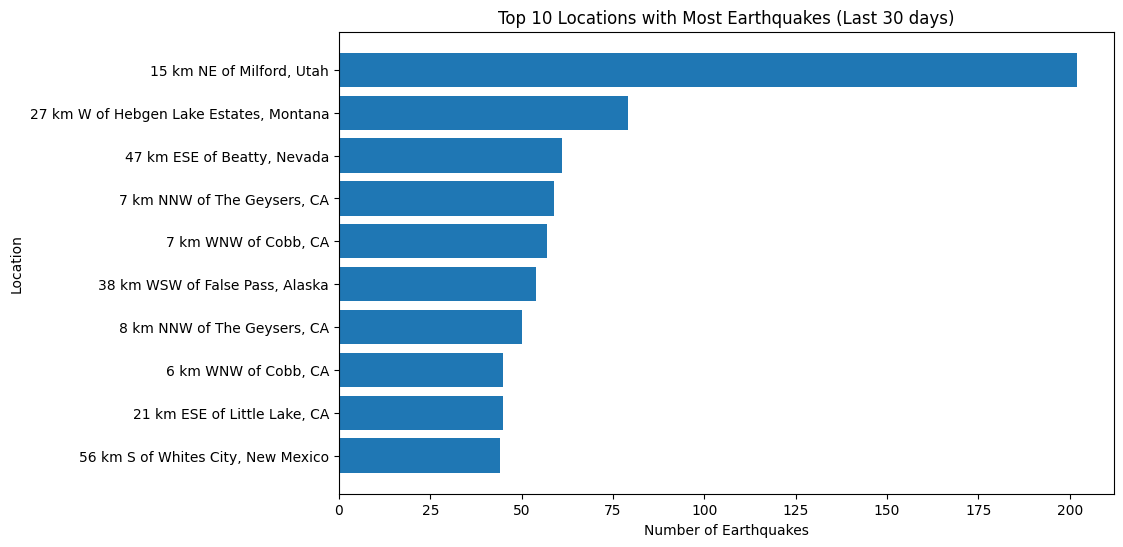

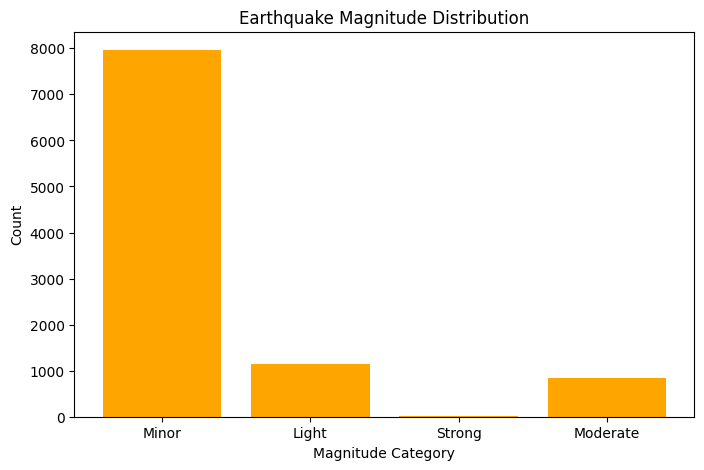

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert top locations to Pandas for plotting
top_loc_pd = top_locations.toPandas()

plt.figure(figsize=(10,6))
plt.barh(top_loc_pd["place"], top_loc_pd["count"])
plt.xlabel("Number of Earthquakes")
plt.ylabel("Location")
plt.title("Top 10 Locations with Most Earthquakes (Last 30 days)")
plt.gca().invert_yaxis()
plt.show()

# Magnitude category distribution
mag_count_pd = mag_count.toPandas()
plt.figure(figsize=(8,5))
plt.bar(mag_count_pd["mag_category"], mag_count_pd["count"], color='orange')
plt.xlabel("Magnitude Category")
plt.ylabel("Count")
plt.title("Earthquake Magnitude Distribution")
plt.show()


In [11]:
from pyspark.sql.functions import to_timestamp, col, date_format

# Convert 'time' to timestamp
eq_df = eq_df.withColumn("time_ts", to_timestamp(col("time")))

# Extract date for aggregation
eq_df = eq_df.withColumn("date", date_format(col("time_ts"), "yyyy-MM-dd"))

eq_df.select("time", "time_ts", "date").show(5)


+--------------------+--------------------+----------+
|                time|             time_ts|      date|
+--------------------+--------------------+----------+
|2025-09-24 17:39:...|2025-09-24 17:39:...|2025-09-24|
|2025-09-24 17:14:...|2025-09-24 17:14:...|2025-09-24|
|2025-09-24 17:13:...|2025-09-24 17:13:...|2025-09-24|
|2025-09-24 17:06:...|2025-09-24 17:06:...|2025-09-24|
|2025-09-24 17:03:...|2025-09-24 17:03:...|2025-09-24|
+--------------------+--------------------+----------+
only showing top 5 rows



+----------+-----+
|      date|count|
+----------+-----+
|2025-08-25|   78|
|2025-08-26|  295|
|2025-08-27|  317|
|2025-08-28|  340|
|2025-08-29|  358|
|2025-08-30|  369|
|2025-08-31|  454|
|2025-09-01|  361|
|2025-09-02|  360|
|2025-09-03|  335|
+----------+-----+
only showing top 10 rows



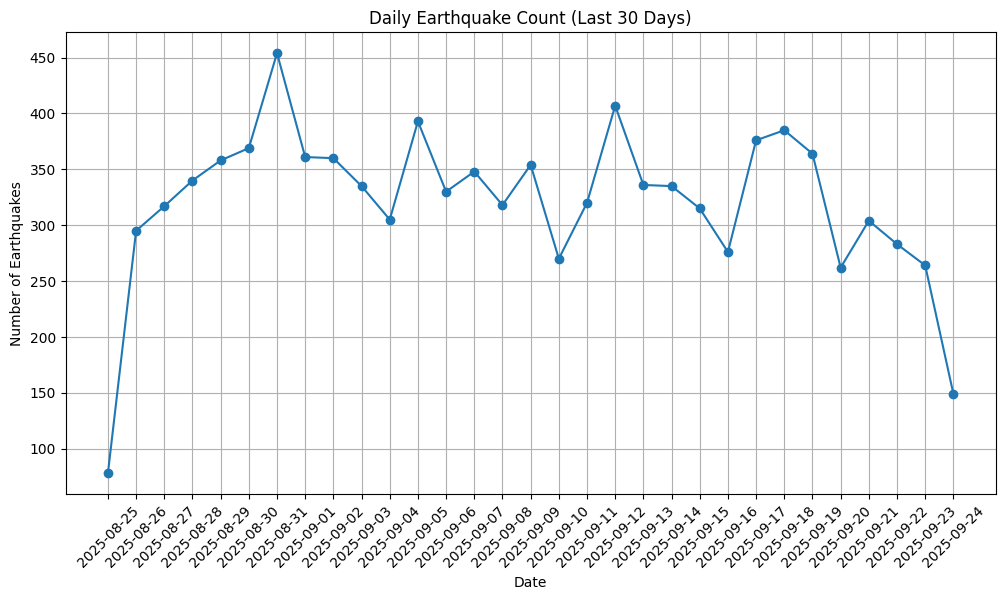

In [12]:
daily_eq = eq_df.groupBy("date").count().orderBy("date")
daily_eq.show(10)

# Convert to Pandas for plotting
daily_eq_pd = daily_eq.toPandas()
plt.figure(figsize=(12,6))
plt.plot(daily_eq_pd["date"], daily_eq_pd["count"], marker='o')
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Number of Earthquakes")
plt.title("Daily Earthquake Count (Last 30 Days)")
plt.grid(True)
plt.show()


In [13]:
strong_eq = eq_df.filter(col("mag") >= 6)
print("Number of strong earthquakes:", strong_eq.count())
strong_eq.show(10)


Number of strong earthquakes: 9
+--------------------+--------+---------+------+---+--------------------+------------+--------------------+----------+
|                time|latitude|longitude| depth|mag|               place|mag_category|             time_ts|      date|
+--------------------+--------+---------+------+---+--------------------+------------+--------------------+----------+
|2025-09-18 18:58:...| 53.1928| 160.5129|  19.5|7.8|127 km E of Petro...|      Strong|2025-09-18 18:58:...|2025-09-18|
|2025-09-18 18:19:...| -3.6145| 135.5258|  10.0|6.1|28 km S of Nabire...|      Strong|2025-09-18 18:19:...|2025-09-18|
|2025-09-16 16:59:...| -5.4051|  153.825|41.023|6.0|208 km SE of Koko...|      Strong|2025-09-16 16:59:...|2025-09-16|
|2025-09-15 16:34:...| 52.6922| 160.7026|24.472|6.0|145 km ESE of Pet...|      Strong|2025-09-15 16:34:...|2025-09-15|
|2025-09-13 02:37:...| 53.1043| 160.2938|39.465|7.4|111 km E of Petro...|      Strong|2025-09-13 02:37:...|2025-09-13|
|2025-09-08 21:4

In [14]:
!pip install folium
import folium

# Create a base map
m = folium.Map(location=[0, 0], zoom_start=2)

# Plot earthquakes (latitude, longitude) as circle markers
for row in strong_eq.select("latitude", "longitude", "mag", "place").collect():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=row["mag"],  # radius proportional to magnitude
        popup=f"{row['place']} | Mag: {row['mag']}",
        color='red',
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

m  # display map in Colab


+----+-----+
|week|count|
+----+-----+
|  35| 2211|
|  36| 2432|
|  37| 2340|
|  38| 2282|
|  39|  696|
+----+-----+



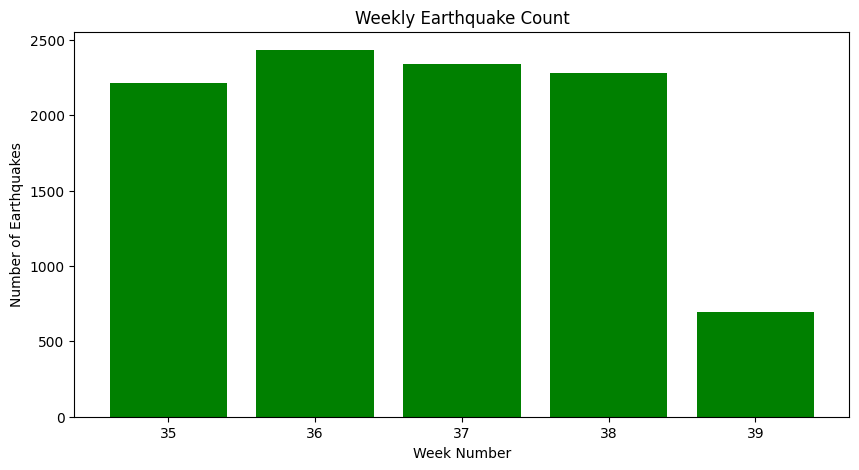

In [15]:
from pyspark.sql.functions import weekofyear

eq_df = eq_df.withColumn("week", weekofyear(col("time_ts")))
weekly_eq = eq_df.groupBy("week").count().orderBy("week")
weekly_eq.show()

# Visualization
weekly_eq_pd = weekly_eq.toPandas()
plt.figure(figsize=(10,5))
plt.bar(weekly_eq_pd["week"], weekly_eq_pd["count"], color='green')
plt.xlabel("Week Number")
plt.ylabel("Number of Earthquakes")
plt.title("Weekly Earthquake Count")
plt.show()


In [16]:
# Magnitude distribution
mag_count.toPandas().to_csv("mag_count.csv", index=False)

# Top locations
top_locations.toPandas().to_csv("top_locations.csv", index=False)

# Daily trend
daily_eq.toPandas().to_csv("daily_eq.csv", index=False)

# Strong earthquakes (for map)
strong_eq.toPandas().to_csv("strong_eq.csv", index=False)
